# 多层感知机的简洁实现
:label:`sec_mlp_concise`

本节将介绍(**通过高级API更简洁地实现多层感知机**)。


In [1]:
import torch
from torch import nn
from d2l import torch as d2l
from IPython import display

In [2]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

## 模型

与softmax回归的简洁实现（ :numref:`sec_softmax_concise`）相比，
唯一的区别是我们添加了2个全连接层（之前我们只添加了1个全连接层）。
第一层是[**隐藏层**]，它(**包含256个隐藏单元，并使用了ReLU激活函数**)。
第二层是输出层。


In [3]:
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Linear(256, 256),
                    nn.ReLU(),
                    nn.Linear(256, 256),
                    nn.ReLU(),
                    nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=256, bias=True)
  (6): ReLU()
  (7): Linear(in_features=256, out_features=10, bias=True)
)

[**训练过程**]的实现与我们实现softmax回归时完全相同，
这种模块化设计使我们能够将与模型架构有关的内容独立出来。


In [4]:
batch_size, lr, num_epochs = 256, 0.1, 10
lossfuc = nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [5]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [6]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 2],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))

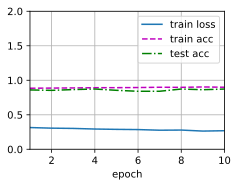

In [9]:
num_epochs = 10
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
train_ch3(net, train_iter, test_iter, lossfuc, num_epochs, optimizer)

In [10]:
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
num_epochs, lr = 10, 0.1
for i in range(num_epochs):
    for x, y in train_iter:
        optimizer.zero_grad() 
        y_hat = net(x)
        loss = lossfuc(y_hat, y)
        loss.mean().backward()
        optimizer.step()
        # print('Training crossentropy loss:{:.4f}'.format(loss.mean().detach().numpy()))
    for x_val, y_val in test_iter:
        y_pre = net(x_val)
        loss_val = lossfuc(y_pre, y_val)
        # print('Validation crossentropy loss: {:.4f}'.format(loss_val.mean().detach().numpy()))

Training crossentropy loss:0.2386
Training crossentropy loss:0.3868
Training crossentropy loss:0.2697
Training crossentropy loss:0.3602
Training crossentropy loss:0.2614
Training crossentropy loss:0.3606
Training crossentropy loss:0.2572
Training crossentropy loss:0.3302
Training crossentropy loss:0.3343
Training crossentropy loss:0.3480
Training crossentropy loss:0.2064
Training crossentropy loss:0.3319
Training crossentropy loss:0.3081
Training crossentropy loss:0.3524
Training crossentropy loss:0.1963
Training crossentropy loss:0.2019
Training crossentropy loss:0.2651
Training crossentropy loss:0.2965
Training crossentropy loss:0.2688
Training crossentropy loss:0.2554
Training crossentropy loss:0.2615
Training crossentropy loss:0.1950
Training crossentropy loss:0.2119
Training crossentropy loss:0.3451
Training crossentropy loss:0.2059
Training crossentropy loss:0.2415
Training crossentropy loss:0.2246
Training crossentropy loss:0.1596
Training crossentropy loss:0.2217
Training cross